# Autoencoder Model on MNIST dataset

In [2]:
import torch

torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook

output_notebook()
%matplotlib inline

plt.rcParams['figure.dpi'] = 200

Loading BokehJS ...

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Model implementation

### Encoder class

In [8]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

### CNN Encoder class

In [4]:
class CNNEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(CNNEncoder, self).__init__()

        # CNN encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),  # [ batch_size, 8, 14, 14 ]
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),  # [ batch_size, 16, 7, 7 ]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),  # [ batch_size, 32, 3, 3 ]
            nn.ReLU()
        )

        # latent space
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dims)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)  # [ batch_size, 32, 3, 3 ]
        x = self.encoder_lin(
            torch.flatten(
                x, start_dim=1
            )
        )  # [ batch_size, 32 * 3 * 3 ] ->  [ batch_size, 128 ] -> [ batch_size, latent_dims ]
        return x


### Decoder class

In [9]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.view((-1, 1, 28, 28))

### CNN Decoder class

In [14]:
class CNNDecoder(nn.Module):
    def __init__(self, latent_dims):
        super(CNNDecoder, self).__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(),
            nn.Linear(128, 3 * 3 * 32), # [ batch_size, 288 ]
            nn.ReLU()
        )

        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0), # [ batch_size, 16, 7, 7]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), # [ batch_size, 8, 14, 14]
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1) # [ batch_size, 1, 28, 28]
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.decoder_cnn(x.unflatten(dim=1, sizes=(32, 3, 3))) # [ batch_size, 288 ] -> [ batch_size, 32, 3, 3] -> [ batch_size, 1, 28, 28]
        return torch.sigmoid(x)

### Autoencoder class

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

### Autoencoder CNN class

In [15]:
class CNNAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(CNNAutoencoder, self).__init__()
        self.encoder = CNNEncoder(latent_dims)
        self.decoder = CNNDecoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

## Training

In [7]:
def train(model, data, optim, criterion, epochs=20):
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)
            optim.zero_grad()
            x_hat = model(x)
            loss = criterion(x_hat, x)
            loss.backward()
            optim.step()
        print(f'epoch:{epoch} loss:{loss}')
    return model

## Dataset

In [8]:
from torch.utils.data import DataLoader

data = DataLoader(
    torchvision.datasets.MNIST(
        '.pytorch/autoencodermnist', transform=torchvision.transforms.ToTensor(), download=True
    ),
    batch_size=128,
    shuffle=True,
    drop_last=True
)

In [8]:
latent_dims = 16
ae = Autoencoder(latent_dims).to(device)
optim = torch.optim.Adam(ae.parameters())
criterion = nn.MSELoss()
autoencoder = train(ae, data, optim, criterion)

epoch:0 loss:0.017505861818790436
epoch:1 loss:0.01469348929822445
epoch:2 loss:0.013206742703914642
epoch:3 loss:0.012991558760404587
epoch:4 loss:0.011333274655044079
epoch:5 loss:0.010835587047040462
epoch:6 loss:0.01065313071012497
epoch:7 loss:0.010580831207334995
epoch:8 loss:0.009721961803734303
epoch:9 loss:0.01094615738838911
epoch:10 loss:0.009810364805161953
epoch:11 loss:0.01034704502671957
epoch:12 loss:0.009544317610561848
epoch:13 loss:0.00858247559517622
epoch:14 loss:0.00950076524168253
epoch:15 loss:0.009303118102252483
epoch:16 loss:0.009792105294764042
epoch:17 loss:0.008658215403556824
epoch:18 loss:0.0089794946834445
epoch:19 loss:0.00883788987994194


In [16]:
latent_dims = 16
cnnae = CNNAutoencoder(latent_dims).to(device)
cnnoptim = torch.optim.Adam(cnnae.parameters())
cnncriterion = nn.MSELoss()
cnnautoencoder = train(cnnae, data, cnnoptim, cnncriterion)

epoch:0 loss:0.024295412003993988
epoch:1 loss:0.015495105646550655
epoch:2 loss:0.013692366890609264
epoch:3 loss:0.012591520324349403
epoch:4 loss:0.011545918881893158
epoch:5 loss:0.011196441017091274
epoch:6 loss:0.011086724698543549
epoch:7 loss:0.010158956050872803
epoch:8 loss:0.011364657431840897
epoch:9 loss:0.009448844008147717
epoch:10 loss:0.009795327670872211
epoch:11 loss:0.009427264332771301
epoch:12 loss:0.009618702344596386
epoch:13 loss:0.008648674935102463
epoch:14 loss:0.010081215761601925
epoch:15 loss:0.008790259249508381
epoch:16 loss:0.00901238527148962
epoch:17 loss:0.008849970065057278
epoch:18 loss:0.009028471074998379
epoch:19 loss:0.008753471076488495


## Visualize latent space

In [18]:
vis_element = []
ys = []


def get_latent(model, data):
    vis_element.clear()
    ys.clear()
    for i, (x, y) in enumerate(data):
        z = model.encoder(x.to(device))
        vis_element.extend(z.to('cpu').detach().numpy())
        ys.extend(y.to('cpu').detach().numpy())


In [ ]:
get_latent(autoencoder, data)

In [19]:
get_latent(cnnautoencoder, data)

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
vis_latent = tsne.fit_transform(vis_element)

In [22]:
from bokeh.transform import linear_cmap

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="vector T-SNE for latent space")

source = ColumnDataSource(data=dict(x1=vis_latent[:, 0],
                                    x2=vis_latent[:, 1],
                                    y=ys,
                                    names=ys))

p.scatter(x="x1", y="x2", size=8, source=source,
          line_color=None,
          fill_color=linear_cmap('y', 'Turbo256', 0, 9),
          legend_field='y'
          )

digit = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                 text_font_size="4pt", text_color="#555555",
                 source=source, text_align='center', render_mode='canvas')
# p.add_layout(digit)

show(p)

In [31]:
def plot_reconstructed(model, r0=vis_element[-1], r1=vis_element[5000], n=24):
    w = 28
    img = np.zeros((n * w, n * w))
    results = np.linspace(r0.reshape(1, -1), r1.reshape(1, -1), num=n)
    for i, y in enumerate(results):
        for j in range(n):
            z = torch.Tensor(y).to(device)
            x_hat = model.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n - 1 - i) * w:(n - 1 - i + 1) * w, j * w:(j + 1) * w] = x_hat
    plt.imshow(img)



In [ ]:
plot_reconstructed(autoencoder)

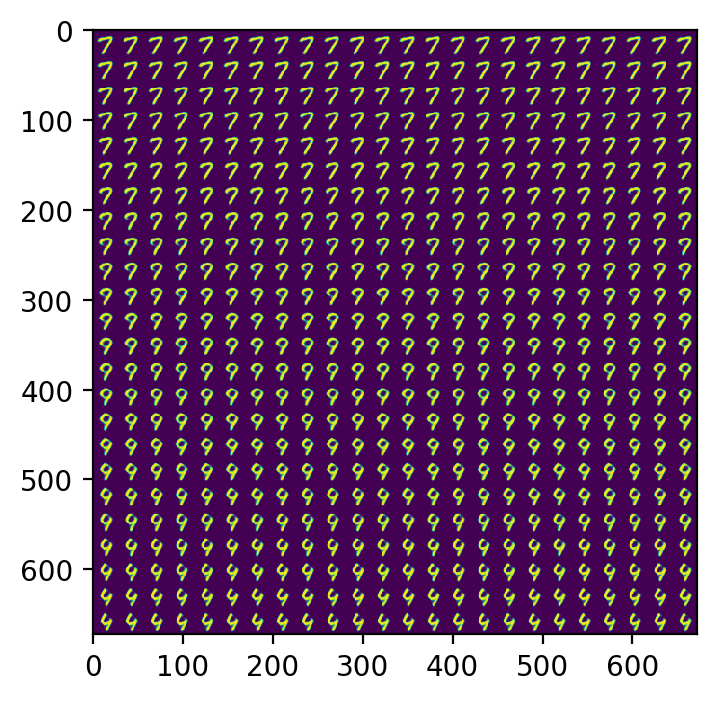

In [32]:
plot_reconstructed(cnnautoencoder)

# Variational Autoencoder

## Model implementation

### Variational Encoder class

In [30]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma * self.N.sample(mu.shape)  # sampled element
        self.kl = (sigma ** 2 + mu ** 2 - torch.log(sigma) - 1 / 2).sum()
        return z

### Variational Autoencoder class

In [41]:
def train_vae(model, data, optim, criterion, epochs=20):
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)
            optim.zero_grad()
            x_hat = model(x)
            loss = ((x - x_hat) ** 2).sum() + model.encoder.kl
            loss.backward()
            optim.step()
        print(f'epoch:{epoch} loss:{loss}')
    return model

In [40]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [42]:
latent_dims = 16
vae = VariationalAutoencoder(latent_dims).to(device)
optim = torch.optim.Adam(vae.parameters())
criterion = nn.MSELoss()

In [45]:
varautoencoder = train_vae(vae, data, optim, criterion)

epoch:0 loss:4704.529296875
epoch:1 loss:4711.77734375
epoch:2 loss:4531.8994140625
epoch:3 loss:4561.1875
epoch:4 loss:4530.0927734375
epoch:5 loss:4596.37841796875
epoch:6 loss:4670.7763671875
epoch:7 loss:4369.171875
epoch:8 loss:4515.3759765625
epoch:9 loss:4370.15380859375
epoch:10 loss:4424.2216796875
epoch:11 loss:4412.14892578125
epoch:12 loss:4536.005859375
epoch:13 loss:4258.1005859375
epoch:14 loss:4437.64794921875
epoch:15 loss:4407.2421875
epoch:16 loss:4475.83349609375
epoch:17 loss:4416.25732421875
epoch:18 loss:4476.36962890625
epoch:19 loss:4374.76171875


### Visualize latent space of variational Autoencoder

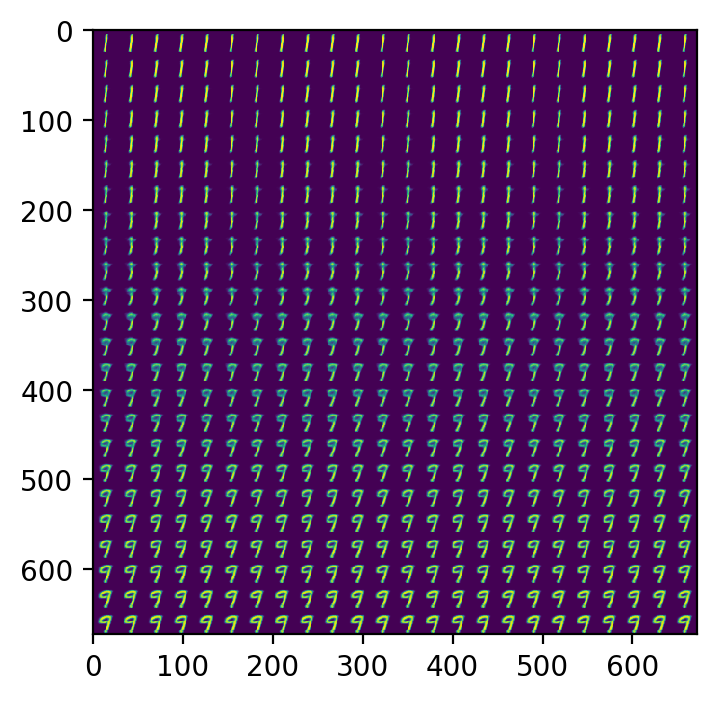

In [46]:
get_latent(varautoencoder, data)
plot_reconstructed(varautoencoder)